# SGD

In [2]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [57]:
class GD:
    def __init__(self, func, func_grad, search_min, search_max, sol_size, learning_rate):
        self.learning_rate = learning_rate
        self.target_func = func
        self.target_func_grad = func_grad
        self.X = np.random.rand(*sol_size) * (search_max - search_min) + search_min
        
    def step(self):
        self.X -= self.learning_rate * self.target_func_grad(self.X)
        return self.target_func(self.X)
    
    def optimize(self, max_steps, min_func=None, closeness=10**-3, early_stopping=False):
        losses = []
        try:
            for _ in range(max_steps):
                loss = self.step()
                losses.append(loss)
                if early_stopping and min_func is not None and np.abs(loss - min_func) <= closeness:
                    break
        except KeyboardInterrupt:
            plt.plot(losses)
            plt.show()
            print(len(losses))
            return self.X
        plt.plot(losses)
        plt.show()
        print(len(losses))
        return self.X

# Случайный поиск с возвратом

In [270]:
class RandomSearch:
    def __init__(self, func, search_min, search_max, sol_size):
        self.f = func
        self.min = search_min
        self.size = sol_size
        self.zone = search_max - self.min
        self.X = np.random.rand(*self.size) * self.zone + self.min
        
    def step(self):
        X_new = np.random.rand(*self.size) * self.zone + self.min
        if self.f(X_new) <= self.f(self.X):
            self.X = X_new
        return self.f(self.X)
            
    def optimize(self, max_steps, min_func=None, closeness=10**-3, early_stopping=False):
        losses = []
        try:
            for _ in range(max_steps):
                loss = self.step()
                losses.append(loss)
                if early_stopping and min_func is not None and np.abs(loss - min_func) <= closeness:
                    break
        except KeyboardInterrupt:
            plt.plot(losses)
            plt.show()
            print(len(losses))
            return self.X
        plt.plot(losses)
        plt.show()
        print(len(losses))
        return self.X

# Генетический алгоритм

In [59]:
class GeneticSearch:
    def __init__(self, func, search_min, search_max, sol_size, population, elite, p_alive, p_mut):
        self.f = func
        self.min = search_min
        self.size = sol_size
        self.zone = search_max - self.min
        #Инициализация популяции
        self.population = np.random.rand(population, *sol_size) * self.zone + self.min
        self.population_size = population
        #Инициализация структурных параметров 
        self.elite_count = int(np.rint(elite * population))
        self.p_alive = p_alive
        self.p_mut = p_mut
        #Инициализация лучшего значения
        self.best = 0
        
    def crossover(self, sample1, sample2):
        if self.size == (1,):
            weight = np.random.rand()
            return weight * sample1 + (1 - weight) * sample2
        else:
            mask = np.random.randint(2, size=self.size)
            result = np.zeros(self.size)
            result[np.where(mask == 1)] = sample1[np.where(mask == 1)]
            result[np.where(mask == 0)] = sample2[np.where(mask == 0)]
            return result
        
    def mutate(self, sample):
        mask = np.random.randint(2, size=self.size)
        s = np.max(np.abs(sample))
        mut = 2 * s * np.random.rand(*self.size) + s
        sample[np.where(mask == 1)] += mut[np.where(mask == 1)]
        return sample
            
    def step(self):
        # Естественный отбор
        results = np.array(list(map(self.f, self.population)))
        
        self.population = self.population[np.argsort(results)]
        
        self.best = self.population[0]
        
        weak_population = self.population[self.elite_count:]
        self.population = self.population[:self.elite_count:]
        
        for el in weak_population:
            rnd = np.random.rand()
            if rnd < self.p_alive:
                self.population = np.vstack((self.population, el))
        
        #Скрещивание
        while self.population.shape[0] < self.population_size:
            parent1 = self.population[np.random.randint(self.elite_count)]
            parent2 = self.population[np.random.randint(self.elite_count)]
            child = self.crossover(parent1, parent2)
            self.population = np.vstack((self.population, child))
        
        #Мутация
        for i in range(self.population.shape[0]):
            rnd = np.random.rand()
            if rnd < self.p_mut:
                self.population[i] = self.mutate(self.population[i])
                
        return self.f(self.best)
    
    def optimize(self, max_steps, min_func=None, closeness=10**-3, patience=10000, early_stopping=False):
        losses = []
        prev_loss = 0.0
        steps_no_change = 0
        try:
            for _ in range(max_steps):
                loss = self.step()
                losses.append(loss)
                if (loss == prev_loss):
                    steps_no_change += 1
                else:
                    steps_no_change = 0
                if early_stopping and steps_no_change >= patience:
                    break
                if early_stopping and min_func is not None and np.abs(loss - min_func) <= closeness:
                    break
                prev_loss = loss
        except KeyboardInterrupt:
            plt.plot(losses)
            plt.show()
            print(len(losses))
            return self.best
        plt.plot(losses)
        plt.show()
        print(len(losses))
        return self.best

# Алгоритм роя частиц.

In [60]:
class BirdsFlock:
    def __init__(self, func, search_min, search_max, sol_size, birds_count, min_speed, max_speed, w, a1, a2):
        self.f = func
        self.size = sol_size
        self.min = search_min
        self.zone = search_max - self.min
        #Инициализация позиций птиц
        self.birds_pos = np.random.rand(birds_count, *sol_size) * self.zone + self.min
        self.best_for_bird = self.birds_pos
        #Инициализация скоростей птиц
        self.min_speed = min_speed
        self.max_speed = max_speed
        self.speed_for_bird = np.random.rand(birds_count, *sol_size) * (max_speed - min_speed) + self.min_speed
        mask = np.random.randint(2, size=(birds_count, *sol_size))
        self.speed_for_bird[np.where(mask == 1)] = -self.speed_for_bird[np.where(mask == 1)]
        #Инициализация параметров алгоритма
        self.w = w
        self.a1 = a1
        self.a2 = a2
        #Инициализация лучшего значения
        results = np.array(list(map(self.f, self.birds_pos)))
        self.best = self.birds_pos[np.argmin(results)]
        self.best_loss = self.f(self.best)
        
    def step(self):
        # Обновляем скорости
        for i in range(self.speed_for_bird.shape[0]):
            rnd1 = np.random.rand()
            rnd2 = np.random.rand()
            self.speed_for_bird[i] = (self.w * self.speed_for_bird[i] +
                                      rnd1 * self.a1 * (self.best_for_bird[i] - self.birds_pos[i]) +
                                      rnd2 * self.a2 * (self.best -             self.birds_pos[i]))
        #Корректируем скорости, чтобы они попадали в интервалы
        self.speed_for_bird[np.where(abs(self.speed_for_bird) > self.max_speed)] =\
        np.sign(self.speed_for_bird[np.where(abs(self.speed_for_bird) > self.max_speed)]) * self.max_speed
        
        self.speed_for_bird[np.where(abs(self.speed_for_bird) < self.min_speed)] =\
        np.sign(self.speed_for_bird[np.where(abs(self.speed_for_bird) < self.min_speed)]) * self.min_speed
        
        #Птицы летят
        self.birds_pos += self.speed_for_bird
        
        #Считаем, что птица не может "вылететь", так как ищем ответ на всей прямой
        #Пересчитываем лучшую позицию для каждой птицы и лучшую позицию вообще
        for i in range(self.birds_pos.shape[0]):
            tmp = self.f(self.birds_pos[i])
            if tmp <= self.f(self.best_for_bird[i]):
                self.best_for_bird[i] = self.birds_pos[i]
                if tmp <= self.best_loss:
                    self.best = self.birds_pos[i]
                    self.best_loss = tmp
        
        return self.best_loss
    
    def optimize(self, max_steps, min_func=None, closeness=10**-3, patience=10000, early_stopping=False):
        losses = []
        prev_loss = 0.0
        steps_no_change = 0
        try:
            for _ in range(max_steps):
                loss = self.step()
                losses.append(loss)
                if (loss == prev_loss):
                    steps_no_change += 1
                else:
                    steps_no_change = 0
                if early_stopping and steps_no_change >= patience:
                    break
                if early_stopping and min_func is not None and np.abs(loss - min_func) <= closeness:
                    break
                prev_loss = loss
        except KeyboardInterrupt:
            plt.plot(losses)
            plt.show()
            print(len(losses))
            return self.best
        plt.plot(losses)
        plt.show()
        print(len(losses))
        return self.best

# Алгоритм роя пчёл

In [61]:
class Hive:
    def __init__(self, func, search_min, search_max, sol_size,
                 scout, best_scout, good_scout, workers_best, workers_good, rad):
        self.f = func
        self.min = search_min
        self.zone = search_max - self.min
        self.size = sol_size
        #Инициализация структурных параметров
        self.scout = scout
        self.best_scout = best_scout
        self.good_scout = good_scout
        self.workers_best = workers_best
        self.workers_good = workers_good
        self.rad = rad
        #Инициализация лучшего значения
        self.best = 0
        self.best_loss = np.inf
    
    def step(self):
        #Посылаем разведчиков
        scouts = np.random.rand(self.scout, *self.size) * self.zone + self.min
        #Получаем результаты
        result = np.array(list(map(self.f, scouts)))
        scouts = scouts[np.argsort(result)]
        tmp = self.f(scouts[0])
        if tmp <= self.best_loss:
            self.best_loss = tmp
            self.best = scouts[0]
        #Отбираем лучшие места
        best_scouts = scouts[:self.best_scout]
        #Отбираем перспективные места
        good_scouts = scouts[self.best_scout:self.best_scout + self.good_scout:]
        #Посылаем работников в лучшие места
        for i in range(best_scouts.shape[0]):
            rnd = np.random.rand(self.workers_best, *self.size) * 2 - 1
            workers_b = rnd*self.rad + best_scouts[i]
        #Посылаем работников в перспективные места
        for i in range(good_scouts.shape[0]):
            rnd = np.random.rand(self.workers_good, *self.size) * 2 - 1
            workers_g = rnd*self.rad + good_scouts[i]
        #Отбираем лучшие результаты
        results_b = np.array(list(map(self.f, workers_b)))
        best_of_the_best = workers_b[np.argmin(results_b)]
        best_res = np.min(results_b)
        
        results_g = np.array(list(map(self.f, workers_g)))
        best_of_good = workers_g[np.argmin(results_g)]
        good_res = np.min(results_g)
        #Обновляем общий лучший результат
        if good_res < best_res:
            best_res = good_res
            best_of_the_best = best_of_good
        if best_res <= self.best_loss:
            self.best_loss = best_res
            self.best = best_of_the_best
        return self.best_loss
    
    def optimize(self, max_steps, min_func=None, closeness=10**-3, patience=10000, early_stopping=False):
        losses = []
        prev_loss = 0.0
        steps_no_change = 0
        try:
            for _ in range(max_steps):
                loss = self.step()
                losses.append(loss)
                if (loss == prev_loss):
                    steps_no_change += 1
                else:
                    steps_no_change = 0
                if early_stopping and steps_no_change >= patience:
                    break
                if early_stopping and min_func is not None and np.abs(loss - min_func) <= closeness:
                    break
                prev_loss = loss
        except KeyboardInterrupt:
            plt.plot(losses)
            plt.show()
            print(len(losses))
            return self.best
        plt.plot(losses)
        plt.show()
        print(len(losses))
        return self.best

# Задача 1.
Задача очень просто поставлена - найти любое простое пятизначное число.
Оптимизируемый функционал:
$$
f(x) = \begin{cases}
0, &\text{$x$ - простое}\\
1, &\text{$x$ - не простое}
\end{cases}
$$

In [62]:
def func(x):
    a = np.rint(x[0])
    i = 2
    while i * i <= a:
        if a % i == 0:
            return 1
        i += 1
    return 0

In [63]:
def func_grad(x):
    # Функция кусочно постоянная, поэтому в каждой точке производная либо 0, либо не существует
    # но мы будем считать, что 0
    return 0

In [64]:
sgd = GD(func, func_grad, search_min=10000, search_max=99999, sol_size=(1,), learning_rate=1)

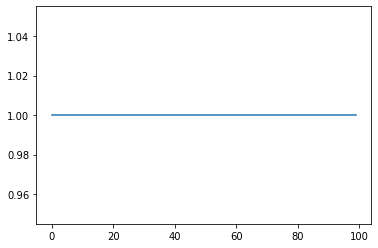

100
CPU times: user 120 ms, sys: 12.1 ms, total: 132 ms
Wall time: 122 ms


array([21705.57193773])

In [65]:
%%time
sgd.optimize(max_steps=100, min_func=0.0)

In [45]:
rs = RandomSearch(func, search_min=10000, search_max=99999, sol_size=(1,))

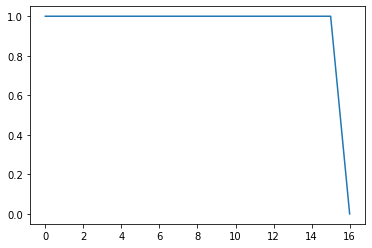

17
CPU times: user 158 ms, sys: 4.29 ms, total: 162 ms
Wall time: 160 ms


array([89112.9303519])

In [46]:
%%time
rs.optimize(max_steps=1000, min_func=0.0)

In [47]:
gs = GeneticSearch(func, search_min=10000, search_max=99999, sol_size=(1,),
                   population=500, elite=0.6, p_alive=0.05, p_mut=0.05)

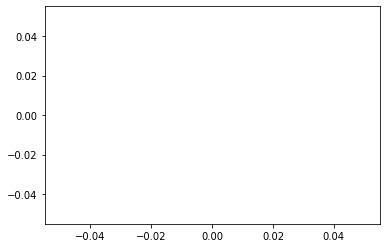

1
CPU times: user 128 ms, sys: 2.84 ms, total: 130 ms
Wall time: 131 ms


array([51612.79193175])

In [49]:
%%time
gs.optimize(max_steps=10000, min_func=0.0)

In [50]:
bf = BirdsFlock(func, search_min=10000, search_max=99999, sol_size=(1,),
                birds_count=100, min_speed=1, max_speed=200, w=0.1, a1=0.4, a2=0.5)

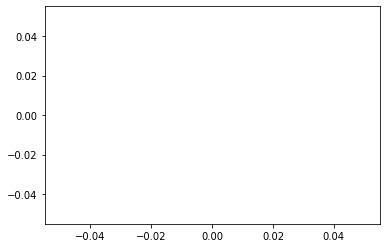

1
CPU times: user 125 ms, sys: 12.7 ms, total: 138 ms
Wall time: 129 ms


array([30558.95206076])

In [51]:
%%time
bf.optimize(max_steps=10000, min_func=0.0)

In [52]:
hive = Hive(func, search_min=10000, search_max=99999, sol_size=(1,),
            scout=1000, best_scout=300, good_scout=200, workers_best=300, workers_good=100, rad=10)

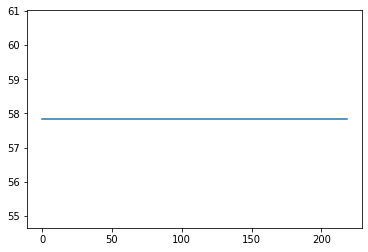

219
[5.54960763 4.09817398 3.19975913] 57.83163328303997
CPU times: user 3.22 s, sys: 7.36 ms, total: 3.23 s
Wall time: 3.23 s


In [205]:
%%time
hive.optimize(max_steps=10000, min_func=0.0)

# Задача 2.

In [411]:
def func2(X):
    return np.sum(X**2)

def func_grad2(X):
    return 2*X

In [412]:
sgd = GD(func2, func_grad2, search_min=-500, search_max=500, sol_size=(3,), learning_rate=0.01)

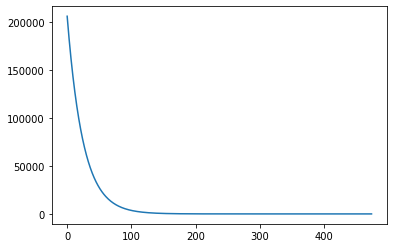

475
[0.02532712 0.01860936 0.00153984] 0.0009901424859982539
CPU times: user 120 ms, sys: 11.1 ms, total: 131 ms
Wall time: 122 ms


In [413]:
%%time
X = sgd.optimize(max_steps=1000000, min_func=0.0, early_stopping=True)
print(X, func2(X))

In [324]:
rs = RandomSearch(func2, search_min=-500, search_max=500, sol_size=(3,))

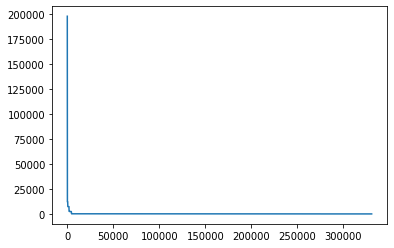

330769
[ 3.67318738 10.57116228 -1.01237193] 126.26667438475774
CPU times: user 7.01 s, sys: 483 ms, total: 7.49 s
Wall time: 7.09 s


In [325]:
%%time
X = rs.optimize(max_steps=3000000, min_func=0.0)
print(X, func2(X))

In [328]:
gs = GeneticSearch(func2, search_min=-500, search_max=500, sol_size=(3,),
                   population=2000, elite=0.3, p_alive=0.1, p_mut=0.3)

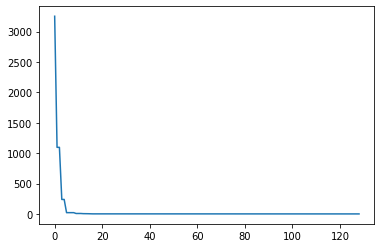

129
[0.00899317 0.02994077 0.00494532] 0.0010017828870596591
CPU times: user 10.6 s, sys: 55.8 ms, total: 10.6 s
Wall time: 10.6 s


In [329]:
%%time
X = gs.optimize(max_steps=5000, min_func=0.0, early_stopping=True, patience=100)
print(X, func2(X))

In [414]:
bf = BirdsFlock(func2, search_min=-500, search_max=500, sol_size=(3,),
                birds_count=500, min_speed=0.00000000001, max_speed=20, w=0.2, a1=0.4, a2=0.4)

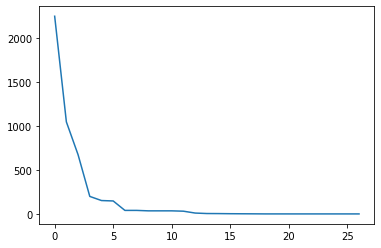

27
[ 0.01836482 -0.00687567 -0.0210871 ] 0.0008292073181052927
CPU times: user 331 ms, sys: 6.33 ms, total: 338 ms
Wall time: 334 ms


In [415]:
%%time
X = bf.optimize(max_steps=10000000, min_func=0.0, early_stopping=True, patience=100)
print(X, func2(X))

In [356]:
hive = Hive(func2, search_min=-500, search_max=500, sol_size=(3,),
            scout=100000, best_scout=5, good_scout=1, workers_best=100, workers_good=50, rad=5)

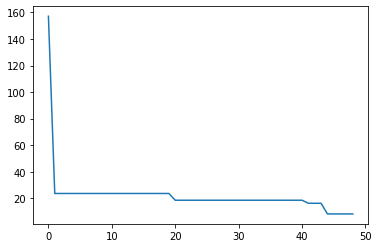

49
[ 2.29472211 -1.64007636  0.52206429] 8.228151158256676
CPU times: user 25.3 s, sys: 67.8 ms, total: 25.3 s
Wall time: 25.4 s


In [357]:
%%time
X = hive.optimize(max_steps=100000, min_func=0.0, early_stopping=True, patience=100)
print(X, func2(X))

# Задача 3.

In [437]:
w_true = np.array([1, 2, 3])

def lin_func(x, w):
    return np.sum(w*x, axis=0)

def MSE(w):
    x = np.random.rand(10, 3)
    pred = lin_func(x, w)
    true = lin_func(x, w_true)
    return np.mean((pred - true)**2)

def MSE_grad(w):
    x = np.random.rand(10, 3)
    a = np.sum(w * x, axis=0)
    a_true = np.sum(w_true * x, axis=0)
    a = a - a_true
    return np.mean(a * x, axis=0)
    

In [438]:
sgd = GD(MSE, MSE_grad, search_min=-100, search_max=100, sol_size=(3,), learning_rate=0.01)

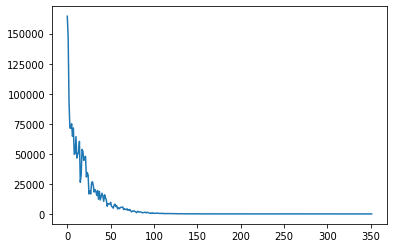

352
[0.99126329 1.991458   2.99473997] 0.0009370985229610975
CPU times: user 152 ms, sys: 10.3 ms, total: 162 ms
Wall time: 156 ms


In [439]:
%%time
X = sgd.optimize(max_steps=1000000, min_func=0.0, early_stopping=True)
print(X, MSE(X))

In [440]:
rs = RandomSearch(MSE, search_min=-100, search_max=100, sol_size=(3,))

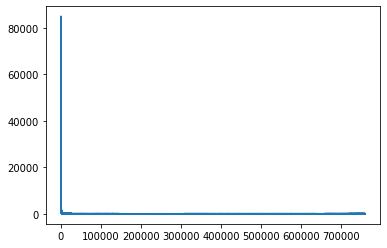

758999
[0.21552167 1.48844552 5.89866117] 78.07806595780144
CPU times: user 1min 4s, sys: 500 ms, total: 1min 5s
Wall time: 1min 4s


In [361]:
%%time
X = rs.optimize(max_steps=3000000, min_func=0.0)
print(X, MSE(X))

In [441]:
gs = GeneticSearch(MSE, search_min=-100, search_max=100, sol_size=(3,),
                   population=1000, elite=0.3, p_alive=0.1, p_mut=0.3)

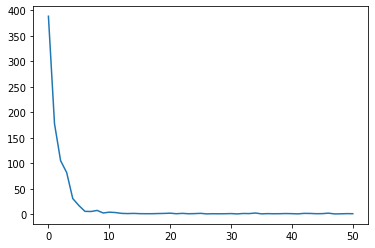

51
[1.36157431 2.09367713 2.98494344] 1.094836093375952
CPU times: user 3.45 s, sys: 38 ms, total: 3.49 s
Wall time: 3.47 s


In [442]:
%%time
X = gs.optimize(max_steps=5000, min_func=0.0, early_stopping=True, patience=100)
print(X, MSE(X))

In [443]:
bf = BirdsFlock(MSE, search_min=-100, search_max=100, sol_size=(3,),
                birds_count=500, min_speed=0.00000000001, max_speed=20, w=0.2, a1=0.4, a2=0.4)

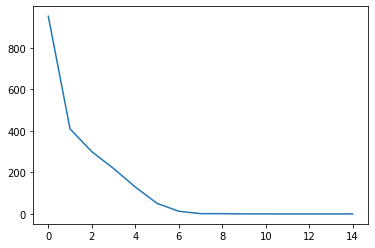

15
[1.00823009 1.99824606 3.00185666] 0.000711877818782802
CPU times: user 585 ms, sys: 15 ms, total: 600 ms
Wall time: 590 ms


In [444]:
%%time
X = bf.optimize(max_steps=10000000, min_func=0.0, early_stopping=True, patience=100)
print(X, MSE(X))

In [449]:
hive = Hive(MSE, search_min=-100, search_max=100, sol_size=(3,),
            scout=100000, best_scout=5, good_scout=1, workers_best=100, workers_good=50, rad=3)

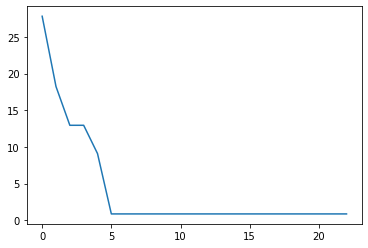

23
[1.22762854 2.23585521 3.00168153] 1.3664414593785477
CPU times: user 1min 4s, sys: 429 ms, total: 1min 5s
Wall time: 1min 5s


In [450]:
%%time
X = hive.optimize(max_steps=100000, min_func=0.0, early_stopping=False, patience=1000)
print(X, MSE(X))

# Задача 4.

In [510]:
def func2(X):
    return np.sum((X ** 2) * np.sin(X))

def func_grad(X):
    return 2*X * np.sin(X) + (X**2) * np.cos(X)

In [511]:
sgd = GD(func2, func_grad, search_min=-200, search_max=200, sol_size=(3,), learning_rate=0.001)

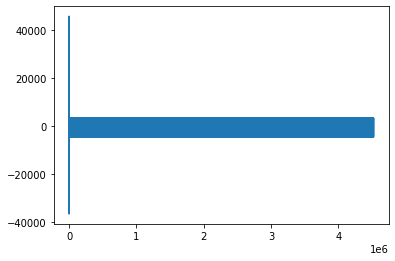

4522062
[63.45677231 63.45677231 36.18353309] 3404.314740794681
CPU times: user 1min 1s, sys: 214 ms, total: 1min 2s
Wall time: 1min 2s


In [512]:
%%time
X = sgd.optimize(max_steps=6000000, early_stopping=True)
print(X, func2(X))

In [523]:
rs = RandomSearch(func2, search_min=-200, search_max=200, sol_size=(3,))

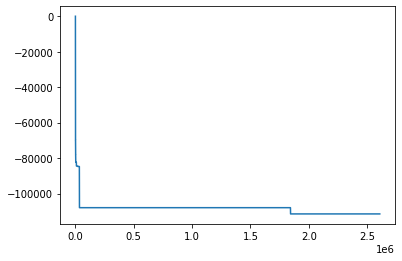

2608993
[ 193.16682207  199.22944544 -190.19555712] -111495.7406968877
CPU times: user 1min 3s, sys: 1.52 s, total: 1min 5s
Wall time: 1min 3s


In [524]:
%%time
X = rs.optimize(max_steps=3000000, min_func=0.0)
print(X, func2(X))

In [538]:
gs = GeneticSearch(func2, search_min=-200, search_max=200, sol_size=(3,),
                   population=2000, elite=0.3, p_alive=0.1, p_mut=0.3)

/Users/azelentsov/PycharmProjects/stohastic/venv/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in square
  


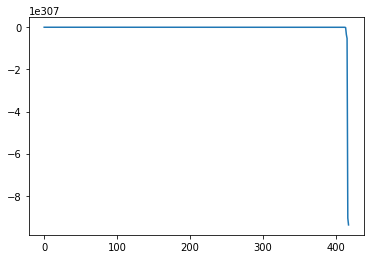

696
[2.68495888e+178 7.50726561e+180 1.69704445e+177] -inf


In [539]:
X = gs.optimize(max_steps=5000, min_func=0.0, early_stopping=False, patience=100)
print(X, func2(X))

In [569]:
bf = BirdsFlock(func2, search_min=-200, search_max=200, sol_size=(3,),
                birds_count=500, min_speed=0.00000000001, max_speed=20, w=0.2, a1=0.4, a2=0.4)

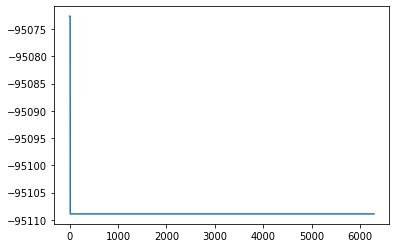

6287
[ 199.10511291 -167.21943407  181.28526906] -44680.34710020496
CPU times: user 1min, sys: 88.1 ms, total: 1min 1s
Wall time: 1min 1s


In [570]:
%%time
X = bf.optimize(max_steps=10000000, min_func=0.0, early_stopping=False, patience=100)
print(X, func2(X))

In [566]:
hive = Hive(func2, search_min=-200, search_max=200, sol_size=(3,),
            scout=100000, best_scout=5, good_scout=1, workers_best=100, workers_good=50, rad=5)

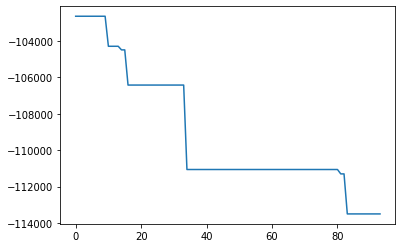

94
[192.78773349 199.46746707 199.4839318 ] -113502.55809352038
CPU times: user 1min, sys: 34.4 ms, total: 1min
Wall time: 1min


In [567]:
%%time
X = hive.optimize(max_steps=100000, min_func=0.0, early_stopping=False, patience=1000)
print(X, func2(X))

# Задача 5

In [600]:
Y_true = np.random.randint(2, size=(10, 10))
kernel = np.ones((3, 3))

from scipy.signal import convolve2d
def make_step(X):
    nbrs_cnt = (convolve2d(X, kernel, mode='same', boundary='fill', fillvalue=0.0) - X).astype('int')
    return (nbrs_cnt == 3) | (X.astype('int') & (nbrs_cnt == 2))

def MAE(X, Y):
    return np.mean(np.abs(X - Y))

def func(X):
    A = np.rint(X).reshape(10, 10)
    A[np.where(A > 1.0)] = 1.0
    A[np.where(A < 0.0)] = 0.0
    return MAE(make_step(A), Y_true)

In [601]:
rs = RandomSearch(func, search_min=0, search_max=1, sol_size=(100,))

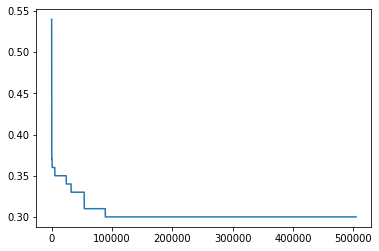

504841
[[4.17467274e-01 7.51466993e-02 4.92597983e-01 4.35502985e-01
  5.95277387e-01 4.38632953e-01 5.94458932e-01 4.58382277e-01
  7.33053009e-01 9.60380586e-01]
 [1.55603996e-01 8.52067722e-01 2.34436386e-01 2.90900746e-02
  5.48031171e-01 8.33637849e-01 4.22493169e-01 5.65698015e-01
  1.12243182e-01 2.74257484e-01]
 [7.93807368e-01 6.43436526e-01 7.12919256e-01 5.76987358e-01
  9.96350639e-02 7.74243015e-02 1.69987486e-01 4.35605369e-01
  5.44834603e-01 4.49788257e-01]
 [1.89724935e-01 3.62996767e-01 4.84943761e-01 4.92537826e-01
  6.50774928e-01 2.91123112e-01 6.35007194e-01 1.19396341e-01
  1.49462869e-01 9.29545086e-01]
 [4.83545011e-01 8.28939884e-02 6.25681646e-01 5.72740795e-01
  3.74883147e-01 1.32287928e-01 3.92132779e-01 7.48532001e-01
  9.12248863e-01 7.03862567e-01]
 [4.98469238e-01 8.93177422e-01 6.59477782e-01 3.98566145e-01
  5.33639411e-01 6.07576036e-01 1.25157766e-01 5.31424266e-01
  2.02383917e-01 5.05707868e-01]
 [6.92851382e-02 3.43181558e-01 2.68769617e-01 5.24

In [596]:
%%time
X = rs.optimize(max_steps=3000000, min_func=0.0)
print(X, func(X))

In [610]:
gs = GeneticSearch(func, search_min=-0, search_max=1, sol_size=(100,),
                   population=600, elite=0.4, p_alive=0.1, p_mut=0.3)

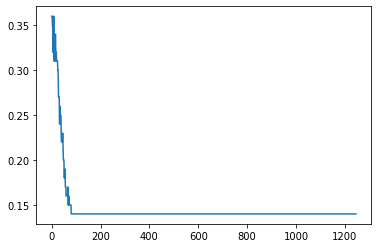

1247
[8.71220983e-01 9.49472064e-01 8.60889015e-01 5.68424231e-01
 9.12807094e-01 3.51894243e-01 1.36987660e-01 3.52751984e-01
 3.51884007e-01 2.07776804e+00 7.49324300e-01 2.95863798e-01
 3.03318403e-01 6.79813024e-01 1.01562341e-01 8.42474630e-01
 1.79128167e-01 3.93365075e-01 6.39717468e-01 1.06209596e-01
 5.72671685e-01 1.65767952e-01 8.91116743e-01 6.94777857e-01
 8.53886737e-01 3.86875213e-01 7.99687713e-01 8.64983604e-02
 8.56697997e-01 6.81642427e-01 4.27320922e-01 1.19405193e-03
 2.99020151e-01 9.71310740e+00 3.78810435e-01 1.77014295e-01
 7.29843469e-01 2.60632867e-01 2.42473677e-01 9.39861967e-01
 5.22826001e-01 5.35104982e-01 9.23677071e-01 1.47477230e-01
 5.96095077e-01 8.32145734e-01 8.90232621e-01 2.89011762e-01
 9.95104838e-01 1.75060197e-01 6.39998045e+00 3.84936285e-01
 4.11266560e-01 7.09038895e-01 1.10671528e-01 3.58354071e-01
 8.89993163e-02 5.04583639e-01 7.41308595e-01 2.16245754e-04
 2.36279559e-01 9.00628671e-01 2.26010723e-01 9.80325419e-01
 6.24115087e-01 2.9

In [611]:
%%time
X = gs.optimize(max_steps=5000, min_func=0.0, early_stopping=False, patience=100)
print(X, func(X))

In [625]:
bf = BirdsFlock(func, search_min=0, search_max=1, sol_size=(100,),
                birds_count=500, min_speed=0.00000000001, max_speed=1, w=0.2, a1=0.4, a2=0.4)

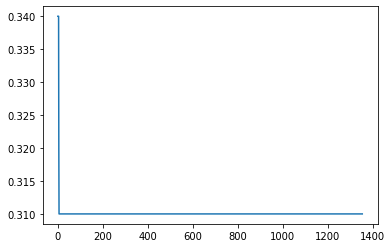

1354
[0.62242658 0.61719918 0.47649102 0.5577756  0.30146588 0.50896778
 0.31441324 0.17871425 0.43900724 0.44207016 0.29320979 0.66880503
 0.38873732 0.14635257 0.46915135 0.77612451 0.45453886 0.41603651
 0.56655688 0.85869528 0.88474132 0.33481305 0.44673601 0.44905601
 0.62752087 0.59408156 0.33111909 0.31513584 0.56596191 0.40030464
 0.32404823 0.37365292 0.07618157 0.69506562 0.21576333 0.81957559
 0.27905824 0.37190929 0.38045504 0.69634189 0.62022646 0.63072797
 0.61281875 0.31780173 0.23916675 0.47222734 0.21035038 0.52743095
 0.29217497 0.54158246 0.44149713 0.56106271 0.62364206 0.67125195
 0.62619184 0.59975876 0.4051565  0.70702134 0.80233125 0.58155187
 0.48767385 0.27109152 0.40470346 0.2650238  0.61789638 0.67564804
 0.36672789 0.49388983 0.5898338  0.73539645 0.4255334  0.27370447
 0.63104647 0.3099737  0.7131268  0.66116357 0.30210298 0.33884535
 0.53389609 0.5681819  0.45480204 0.69716495 0.62343283 0.61672298
 0.44703966 0.69300777 0.42432765 0.28009587 0.67902606 0

In [626]:
%%time
X = bf.optimize(max_steps=10000000, min_func=0.0, early_stopping=False, patience=100)
print(X, func(X))

In [641]:
hive = Hive(func, search_min=0, search_max=1, sol_size=(100,),
            scout=100000, best_scout=10, good_scout=5, workers_best=10, workers_good=5, rad=0.1)

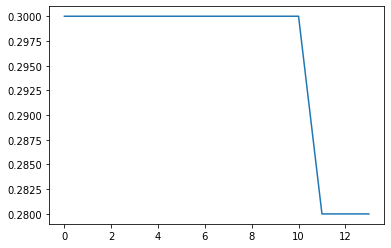

14
[0.96419244 0.51509555 0.82637493 0.72721859 0.54994386 0.09375155
 0.35917068 0.01411073 0.39640922 0.08163264 0.01832506 0.90962325
 0.31403919 0.91281091 0.23741917 0.50288532 0.32930272 0.0965601
 0.75554753 0.955071   0.89165416 0.15982296 0.6344477  0.1166836
 0.92578403 0.71135475 0.13056804 0.02941809 0.73614934 0.32576808
 0.10230733 0.31546791 0.16576936 0.2654346  0.72435216 0.95914114
 0.87114382 0.00728465 0.60490051 0.04865881 0.51798483 0.52226178
 0.04883709 0.86277064 0.77226937 0.15052257 0.00695539 0.23468106
 0.88378444 0.45752414 0.55148552 0.35876588 0.17578714 0.94864583
 0.36169421 0.80009641 0.77706699 0.43781549 0.70713602 0.00651392
 0.36011625 0.48844251 0.9950524  0.88069268 0.74353636 0.34180619
 0.74784697 0.41576668 0.86139552 0.23949051 0.40628775 0.15648119
 0.89546722 0.91388483 0.70322779 0.38719422 0.97254585 0.19620033
 0.05437212 0.89423301 0.48780498 0.17766135 0.19424521 0.12438206
 0.92977486 0.57754123 0.43457776 0.20895629 0.04878397 0.019

In [642]:
%%time
X = hive.optimize(max_steps=100000, min_func=0.0, early_stopping=False, patience=1000)
print(X, func(X))